# Importing Libraries

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader
import random
from PIL import Image
import PIL.ImageOps
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import dataloader
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import euclidean
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Code for training dataset creation

In [ ]:
def split_pairs_by_writer_folders(data_folder):
    writer_folders = os.listdir(data_folder)
    similar_pairs = []
    dissimilar_pairs = []

    for folder in writer_folders:
        folder_path = os.path.join(data_folder, folder)
        images = os.listdir(folder_path)

        # Generate all possible pairs of images within the folder
        image_pairs = [(os.path.join(folder_path, images[i]), os.path.join(folder_path, images[j])) for i in range(len(images)) for j in range(i + 1, len(images))]

        # Shuffle the pairs randomly
        random.shuffle(image_pairs)

        # Select 6 random similar pairs and assign label 1
        similar_pairs.extend([(image1_path, image2_path, 1) for image1_path, image2_path in image_pairs[:6]])

        # Select 6 random dissimilar pairs from different writer folders and assign label 0
        other_writer_folders = writer_folders.copy()
        other_writer_folders.remove(folder)

        for _ in range(6):
            random_writer_folder = random.choice(other_writer_folders)
            other_writer_folders.remove(random_writer_folder)

            other_folder_path = os.path.join(data_folder, random_writer_folder)
            other_images = os.listdir(other_folder_path)
            random_image = random.choice(other_images)

            dissimilar_pairs.append((os.path.join(folder_path, random.choice(images)), os.path.join(other_folder_path, random_image), 0))

    return similar_pairs, dissimilar_pairs


data_folder = '/content/drive/MyDrive/dataset/train'

similar_pairs, dissimilar_pairs = split_pairs_by_writer_folders(data_folder)

print(f"Number of similar writer pairs: {len(similar_pairs)}")
print(f"Number of dissimilar writer pairs: {len(dissimilar_pairs)}")


In [ ]:
similar_pairs

In [ ]:
dissimilar_pairs

In [ ]:
pairs=[]
pairs.extend(similar_pairs)
pairs.extend(dissimilar_pairs)
pairs

In [ ]:
len(pairs)

16224

In [ ]:
df = pd.DataFrame(pairs, columns=['image1_path', 'image2_path', 'label'])

In [ ]:
df.head()

,image1_path,image2_path,label
0,/content/drive/MyDrive/dataset/train/P2253/B3.jpg,/content/drive/MyDrive/dataset/train/P2253/B0.jpg,1
1,/content/drive/MyDrive/dataset/train/P2253/B1.jpg,/content/drive/MyDrive/dataset/train/P2253/B3.jpg,1
2,/content/drive/MyDrive/dataset/train/P2253/B2.jpg,/content/drive/MyDrive/dataset/train/P2253/B3.jpg,1
3,/content/drive/MyDrive/dataset/train/P2253/B2.jpg,/content/drive/MyDrive/dataset/train/P2253/B0.jpg,1
4,/content/drive/MyDrive/dataset/train/P2253/B1.jpg,/content/drive/MyDrive/dataset/train/P2253/B0.jpg,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16224 entries, 0 to 16223
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image1_path  16224 non-null  object
 1   image2_path  16224 non-null  object
 2   label        16224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 380.4+ KB


In [ ]:
# Shuffle the samples in the DataFrame
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
data=shuffled_df.copy()

In [ ]:
data.to_csv("/content/drive/MyDrive/dataset/Training_Dataset.csv",index=False)

# Loading Training Dataset

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/dataset/Training_Dataset.csv")

In [ ]:
data.head(5)

,image1_path,image2_path,label
0,/content/drive/MyDrive/dataset/train/P157/B4.jpg,/content/drive/MyDrive/dataset/train/P1263/B1.jpg,0
1,/content/drive/MyDrive/dataset/train/P1683/B0.jpg,/content/drive/MyDrive/dataset/train/P1683/B6.jpg,1
2,/content/drive/MyDrive/dataset/train/P1916/B2.jpg,/content/drive/MyDrive/dataset/train/P1916/B0.jpg,1
3,/content/drive/MyDrive/dataset/train/P758/B4.jpg,/content/drive/MyDrive/dataset/train/P758/A1.jpg,1
4,/content/drive/MyDrive/dataset/train/P226/B2.jpg,/content/drive/MyDrive/dataset/train/P226/A2.jpg,1


# Building Siamese Network Architecture

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1)
    self.bn1 = nn.BatchNorm2d(num_features=96)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride= 2)
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
    self.bn2 = nn.BatchNorm2d(num_features=256)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout1 = nn.Dropout(p=0.3)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout2 = nn.Dropout(p=0.3)
    self.fc1= nn.Linear(in_features=108800, out_features=1024)
    self.dropout3 = nn.Dropout(p=0.5)
    self.fc2= nn.Linear(in_features=1024,out_features=128)
    self.relu = nn.ReLU(inplace = True)

  def forward(self, x1, x2):
    x1 = self.conv1(x1)
    x1 = self.relu(x1)
    x1 = self.bn1(x1)
    x1 = self.maxpool1(x1)
    x1 = self.conv2(x1)
    x1 = self.relu(x1)
    x1 = self.bn2(x1)
    x1 = self.maxpool2(x1)
    x1 = self.dropout1(x1)
    x1 = self.conv3(x1)
    x1 = self.relu(x1)
    x1 = self.conv4(x1)
    x1 = self.relu(x1)
    x1 = self.maxpool3(x1)
    x1 = self.dropout2(x1)
    x1 = x1.view(x1.size()[0],-1)
    x1 = self.fc1(x1)
    x1 = self.relu(x1)
    x1 = self.dropout3(x1)
    x1 = self.fc2(x1)

    x2 = self.conv1(x2)
    x2 = self.relu(x2)
    x2 = self.bn1(x2)
    x2 = self.maxpool1(x2)
    x2 = self.conv2(x2)
    x2 = self.relu(x2)
    x2 = self.bn2(x2)
    x2 = self.maxpool2(x2)
    x2 = self.dropout1(x2)
    x2 = self.conv3(x2)
    x2 = self.relu(x2)
    x2 = self.conv4(x2)
    x2 = self.relu(x2)
    x2 = self.maxpool3(x2)
    x2 = self.dropout2(x2)
    x2 = x2.view(x2.size()[0],-1)
    x2 = self.fc1(x2)
    x2 = self.relu(x2)
    x2 = self.dropout3(x2)
    x2 = self.fc2(x2)
    return x1, x2




# Contrastive Loss Function

In [ ]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=1.0, constant1=1, constant2=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.constant1 = torch.tensor(constant1, dtype=torch.float32)
        self.constant2 = torch.tensor(constant2, dtype=torch.float32)

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, p=2)
        loss_contrastive = torch.mean(
            (label) * self.constant1 * torch.pow(euclidean_distance, 2)
            + (1 - label) * self.constant2
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive


# Creating DataLoader for training and validation

In [ ]:
from torchvision.transforms import ToTensor

class SiameseDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load the image using OpenCV
        image1 = Image.open(self.df.iloc[idx, 0])
        image2 = Image.open(self.df.iloc[idx, 1])

        # Apply the transformation pipeline if provided
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        label = self.df.iloc[idx, 2]

        return image1, image2, torch.tensor(label, dtype=torch.float32)

In [ ]:
transform=transforms.Compose(
        [transforms.Resize((155, 220)), transforms.ToTensor()])

In [ ]:
 # Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(SiameseDataset(data.iloc[0:16000, :], transform=transform),
                        shuffle=True,
                        num_workers=2,
                        batch_size=32)

In [ ]:
 # Load the dataset as pytorch tensors using dataloader
eval_dataloader = DataLoader(SiameseDataset(data.iloc[16000:, :], transform=transform),
                        shuffle=True,
                        num_workers=2,
                        batch_size=32)

# Code for training

In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()

# Declare Loss Function
criterion = ContrastiveLoss()

# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4, weight_decay=0.0005)
scheduler = ExponentialLR(optimizer, gamma=0.9)


In [ ]:
def train(train_dataloader):
    loss=[]
    counter=[]
    iteration_number = 0
    for i, data in enumerate(train_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      optimizer.zero_grad()
      output1,output2 = net(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss_contrastive.backward()
      optimizer.step()
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(train_dataloader)

In [ ]:
def eval(eval_dataloader):
    loss=[]
    counter=[]
    iteration_number = 0
    for i, data in enumerate(eval_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      output1,output2 = net(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(eval_dataloader)

In [ ]:
best_eval_loss = 9999
for epoch in range(1,30):
  train_loss = train(train_dataloader)
  eval_loss = eval(eval_dataloader)
  print("Epoch:",epoch)
  print(f"Training loss{train_loss}")
  print("-"*10)
  print(f"Eval loss{eval_loss}")
  scheduler.step()

  if eval_loss<best_eval_loss:
    best_eval_loss = eval_loss
    print("-"*10)
    print(f"Best Eval loss{best_eval_loss}")
    torch.save(net.state_dict(), "/content/drive/MyDrive/dataset/SaraSwati_Writes_Final_Model.pth")
    print("Model Saved Successfully")

Epoch: 1
Training loss0.000770075845360756
----------
Eval loss0.043544108770331554
----------
Best Eval loss0.043544108770331554
Model Saved Successfully
Epoch: 2
Training loss0.0005667633628845214
----------
Eval loss0.0398093258239785
----------
Best Eval loss0.0398093258239785
Model Saved Successfully
Epoch: 3
Training loss0.0005431532354950905
----------
Eval loss0.038464926943487056
----------
Best Eval loss0.038464926943487056
Model Saved Successfully
Epoch: 4
Training loss0.0005239110862612725
----------
Eval loss0.0371349609019805
----------
Best Eval loss0.0371349609019805
Model Saved Successfully
Epoch: 5
Training loss0.000511008471429348
----------
Eval loss0.0357029739083076
----------
Best Eval loss0.0357029739083076
Model Saved Successfully
Epoch: 6
Training loss0.0005047732516527176
----------
Eval loss0.0327218302658626
----------
Best Eval loss0.0327218302658626
Model Saved Successfully
Epoch: 7
Training loss0.0004891057934761047
----------
Eval loss0.0346544251150014

#Loading the trained siamese network

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
net = SiameseNetwork().to(device)

# Load the saved state dictionary
state_dict = torch.load("/content/drive/MyDrive/dataset/SaraSwati_Writes_Final_Model.pth")

# Load the state dictionary into the model
net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
import pickle
with open('/content/drive/MyDrive/dataset/SaraSwati_Writes_Final_Model.pkl', 'wb') as f:
    pickle.dump(net, f)

print("Model saved as .pkl successfully.")

Model saved as .pkl successfully.


# Extract output features of the siamese model

In [ ]:
def extract_features(model,data):  #type(data)-->Dataframe
    model.eval()
    features=[]
    # Iterate over the rows of the DataFrame starting from index 1600
    for sample in data.iloc[:, :].values:
        # Load the image using PIL
        image1 = Image.open(sample[0])
        image2 = Image.open(sample[1])
        # Apply the transformation pipeline
        transformed_image1 = transform(image1)
        transformed_image2 = transform(image2)

        # Move the tensors to the appropriate device
        transformed_image1 = transformed_image1.to(device)
        transformed_image2 = transformed_image2.to(device)

        # Add an extra dimension to match the model input shape
        transformed_image1 = transformed_image1.unsqueeze(0)
        transformed_image2 = transformed_image2.unsqueeze(0)

        # Forward pass through the model
        with torch.no_grad():
            feature=[]
            output1, output2= model(transformed_image1, transformed_image2)
            output1 = output1/torch.norm(output1)
            output2 = output2/torch.norm(output2)
            output1 = output1.cpu().numpy()
            output2 = output2.cpu().numpy()
            feature.append(output1)
            feature.append(output2)
        features.append(feature)
    return features


In [ ]:
train_features = extract_features(net,data.iloc[:16000,:])
train_labels = data.iloc[:16000,:]['label']

In [ ]:
np.array(train_features).shape

(16000, 2, 1, 128)

In [ ]:
val_data=pd.read_csv("/content/drive/MyDrive/dataset/val.csv")
val_data_copy = val_data.copy()

# Concatenate string to the start of each value in columns 1 and 2
string_to_concat = "/content/drive/MyDrive/dataset/val/"

val_data_copy.iloc[:, 0:2] = string_to_concat + val_data_copy.iloc[:, 0:2].astype(str)

val_features = extract_features(net,val_data_copy)


In [ ]:
train_features=np.array(train_features)
val_features=np.array(val_features)

In [ ]:
np.array(val_features).shape

(5770, 2, 1, 128)

In [ ]:
val_labels = np.asarray(val_data['label'])

In [ ]:
train_features_reshaped = np.squeeze(train_features)
print(train_features_reshaped.shape)

train_features_reshaped = np.reshape(train_features_reshaped, train_features.shape)

train_features_flattened = np.reshape(train_features_reshaped, (train_features.shape[0], -1))
train_features_flattened.shape

(16000, 2, 128)


(16000, 256)

In [ ]:
val_features_reshaped = np.squeeze(val_features)
print(val_features_reshaped.shape)

val_features_reshaped = np.reshape(val_features_reshaped, val_features.shape)

val_features_flattened = np.reshape(val_features_reshaped, (val_features.shape[0], -1))
val_features_flattened.shape

(5770, 2, 128)


(5770, 256)

# Classification using KNN

In [ ]:
def knn_fit(train_features, train_labels,k):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(train_features, train_labels)
    joblib.dump(knn, '/content/drive/MyDrive/dataset/knn_model.pkl')


In [ ]:
def knn_predict(test_features):
    knn = joblib.load('/content/drive/MyDrive/dataset/knn_model.pkl')
    predicted_labels = knn.predict(test_features)
    probabilities = knn.predict_proba(test_features)[:,1]
    return predicted_labels, probabilities


In [ ]:
knn_fit(np.array(train_features_flattened), np.array(train_labels),100)

In [ ]:
predicted_labels1, probabilities1 = knn_predict( np.array(val_features_flattened))

In [ ]:
f1_knn = f1_score(val_labels, predicted_labels1)
auc_knn = roc_auc_score(val_labels, probabilities1)
acc_knn = accuracy_score(val_labels, predicted_labels1)

print("F1 Score:", f1_knn)
print("AUC:", auc_knn)
print("Accuracy",acc_knn)

F1 Score: 0.7752465147908875
AUC: 0.8440000720874421
Accuracy 0.7708838821490468


# Classification using SVC

In [ ]:
def svc_fit(train_features, train_labels,kernel='rbf'):
    svm = SVC(kernel = kernel, probability = True)
    svm.fit(train_features, train_labels)
    joblib.dump(svm, '/content/drive/MyDrive/dataset/svc_model.pkl')


In [ ]:
def svc_predict(test_features):
  svm = joblib.load('/content/drive/MyDrive/dataset/svc_model.pkl')
  predicted_labels = svm.predict(test_features)
  probabilities = svm.predict_proba(test_features)[:,1]
  return predicted_labels, probabilities

In [ ]:
svc_fit(np.array(train_features_flattened), np.array(train_labels))

In [ ]:
predicted_labels2, probabilities2 = svc_predict( np.array(val_features_flattened))

In [ ]:
f1_svc = f1_score(val_labels, predicted_labels2)
auc_svc = roc_auc_score(val_labels, probabilities2)
acc_svc = accuracy_score(val_labels, predicted_labels2)

print("F1 Score:", f1_svc)
print("AUC:", auc_svc)
print("Accuracy",acc_svc)

F1 Score: 0.7620391603457399
AUC: 0.8426081236539924
Accuracy 0.7662045060658579


# Classification using Adaboost with base estimator as Gradient Boosting Classifier

In [ ]:
def adaboost_fit(train_features, train_labels,kernel='rbf'):
    base_estimator = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1)
    adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=10, learning_rate=1.0)
    adaboost.fit(train_features, train_labels)
    joblib.dump(adaboost, '/content/drive/MyDrive/dataset/adaboost_model.pkl')


In [ ]:
def adaboost_predict(test_features):
  adaboost = joblib.load('/content/drive/MyDrive/dataset/adaboost_model.pkl')
  predicted_labels = adaboost.predict(test_features)
  probabilities = adaboost.predict_proba(test_features)[:,1]
  return predicted_labels, probabilities

In [ ]:
adaboost_fit(np.array(train_features_flattened), np.array(train_labels))

In [ ]:
predicted_labels3, probabilities3 = adaboost_predict( np.array(val_features_flattened))

In [ ]:
f1_gb = f1_score(val_labels, predicted_labels3)
auc_gb = roc_auc_score(val_labels, probabilities3)
acc_gb = accuracy_score(val_labels, predicted_labels3)

print("F1 Score:", f1_gb)
print("AUC:", auc_gb)
print("Accuracy",acc_gb)

F1 Score: 0.7658031088082902
AUC: 0.825324318398217
Accuracy 0.7649913344887348


# Classification using combined results of above classifiers (similar to ensemble method)

In [ ]:
final_proba=[]
final_label=[]
for i in range(len(probabilities2)):
  if probabilities1[i] > 0.5 and probabilities2[i] > 0.5:
    proba = max(probabilities1[i], probabilities2[i] )
  if probabilities2[i] > 0.5 and probabilities3[i] > 0.5:
    proba = max(probabilities2[i], probabilities3[i] )
  if probabilities1[i] > 0.5 and probabilities3[i] > 0.5:
    proba = max(probabilities1[i], probabilities3[i] )
  if probabilities1[i] > 0.5 and probabilities2[i] > 0.5 and probabilities3[i] > 0.5:
    proba = max(probabilities1[i],probabilities2[i], probabilities3[i] )
  if probabilities1[i] < 0.5 and probabilities2[i] < 0.5:
    proba = min(probabilities1[i], probabilities2[i] )
  if probabilities2[i] < 0.5 and probabilities3[i] < 0.5:
    proba = min(probabilities2[i], probabilities3[i] )
  if probabilities1[i] < 0.5 and probabilities3[i] < 0.5:
    proba = min(probabilities1[i], probabilities3[i] )
  if probabilities1[i] < 0.5 and probabilities2[i] < 0.5 and probabilities3[i] < 0.5:
    proba = min(probabilities1[i],probabilities2[i], probabilities3[i] )
  final_proba.append(proba)
  if proba > 0.5:
    final_label.append(1)
  else:
    final_label.append(0)


In [ ]:
f1_ensemble = f1_score(val_labels, final_label)
auc_ensemble = roc_auc_score(val_labels, final_proba)
acc_ensemble = accuracy_score(val_labels, final_label)

# Print the F1 score and AUC
print("F1 Score:", f1_ensemble)
print("AUC:", auc_ensemble)
print("Accuracy",acc_ensemble)

F1 Score: 0.769845405593191
AUC: 0.8449945183507596
Accuracy 0.770363951473137


# Comparison Graph

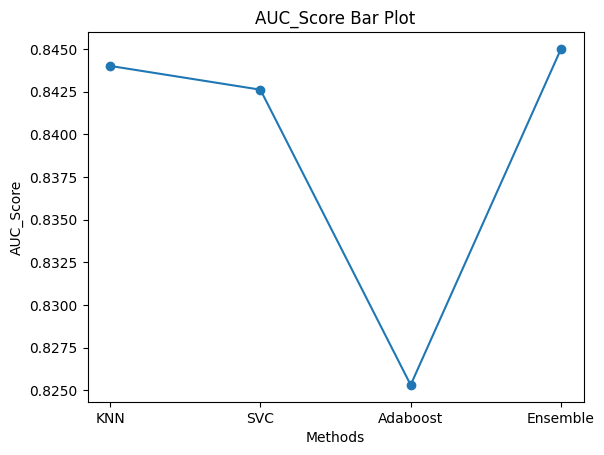

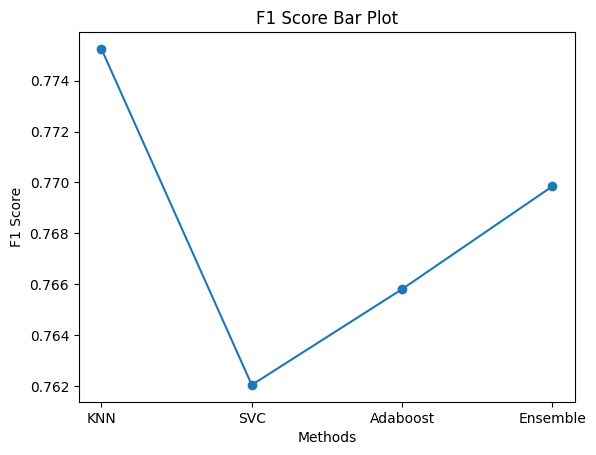

In [ ]:
# Sample data
x = ['KNN','SVC','Adaboost','Ensemble']
y = [auc_knn,auc_svc,auc_gb,auc_ensemble]

# Create plot
plt.plot(x, y, marker='o')

# Add labels and title
plt.xlabel('Methods')
plt.ylabel('AUC_Score')
plt.title('AUC_Score Bar Plot')

# Display the plot
plt.show()


# Sample data
x = ['KNN','SVC','Adaboost','Ensemble']
y = [f1_knn,f1_svc,f1_gb,f1_ensemble]

# Create plot
plt.plot(x, y, marker='o')

# Add labels and title
plt.xlabel('Methods')
plt.ylabel('F1 Score')
plt.title('F1 Score Bar Plot')

# Display the plot
plt.show()

#Visual Result

Upon Training set

In [ ]:
with open('/content/drive/MyDrive/dataset/SaraSwati_Writes_Final_Model.pkl', 'rb') as f:
    siamese_model = pickle.load(f)
knn = joblib.load('/content/drive/MyDrive/dataset/knn_model.pkl')

train_data=pd.read_csv("/content/drive/MyDrive/dataset/Training_Dataset.csv")
train_features = extract_features(net,train_data.iloc[:100,0:2])
train_features=np.array(train_features)
train_features_reshaped = np.squeeze(train_features)
train_features_reshaped = np.reshape(train_features_reshaped, train_features.shape)
train_features_flattened = np.reshape(train_features_reshaped, (train_features.shape[0], -1))
train_features_flattened.shape

training_data=train_data.iloc[:100,0:2]
train_labels = np.asarray(train_data['label'].iloc[:100])
predicted_labels, _ = knn_predict( np.array(train_features_flattened))


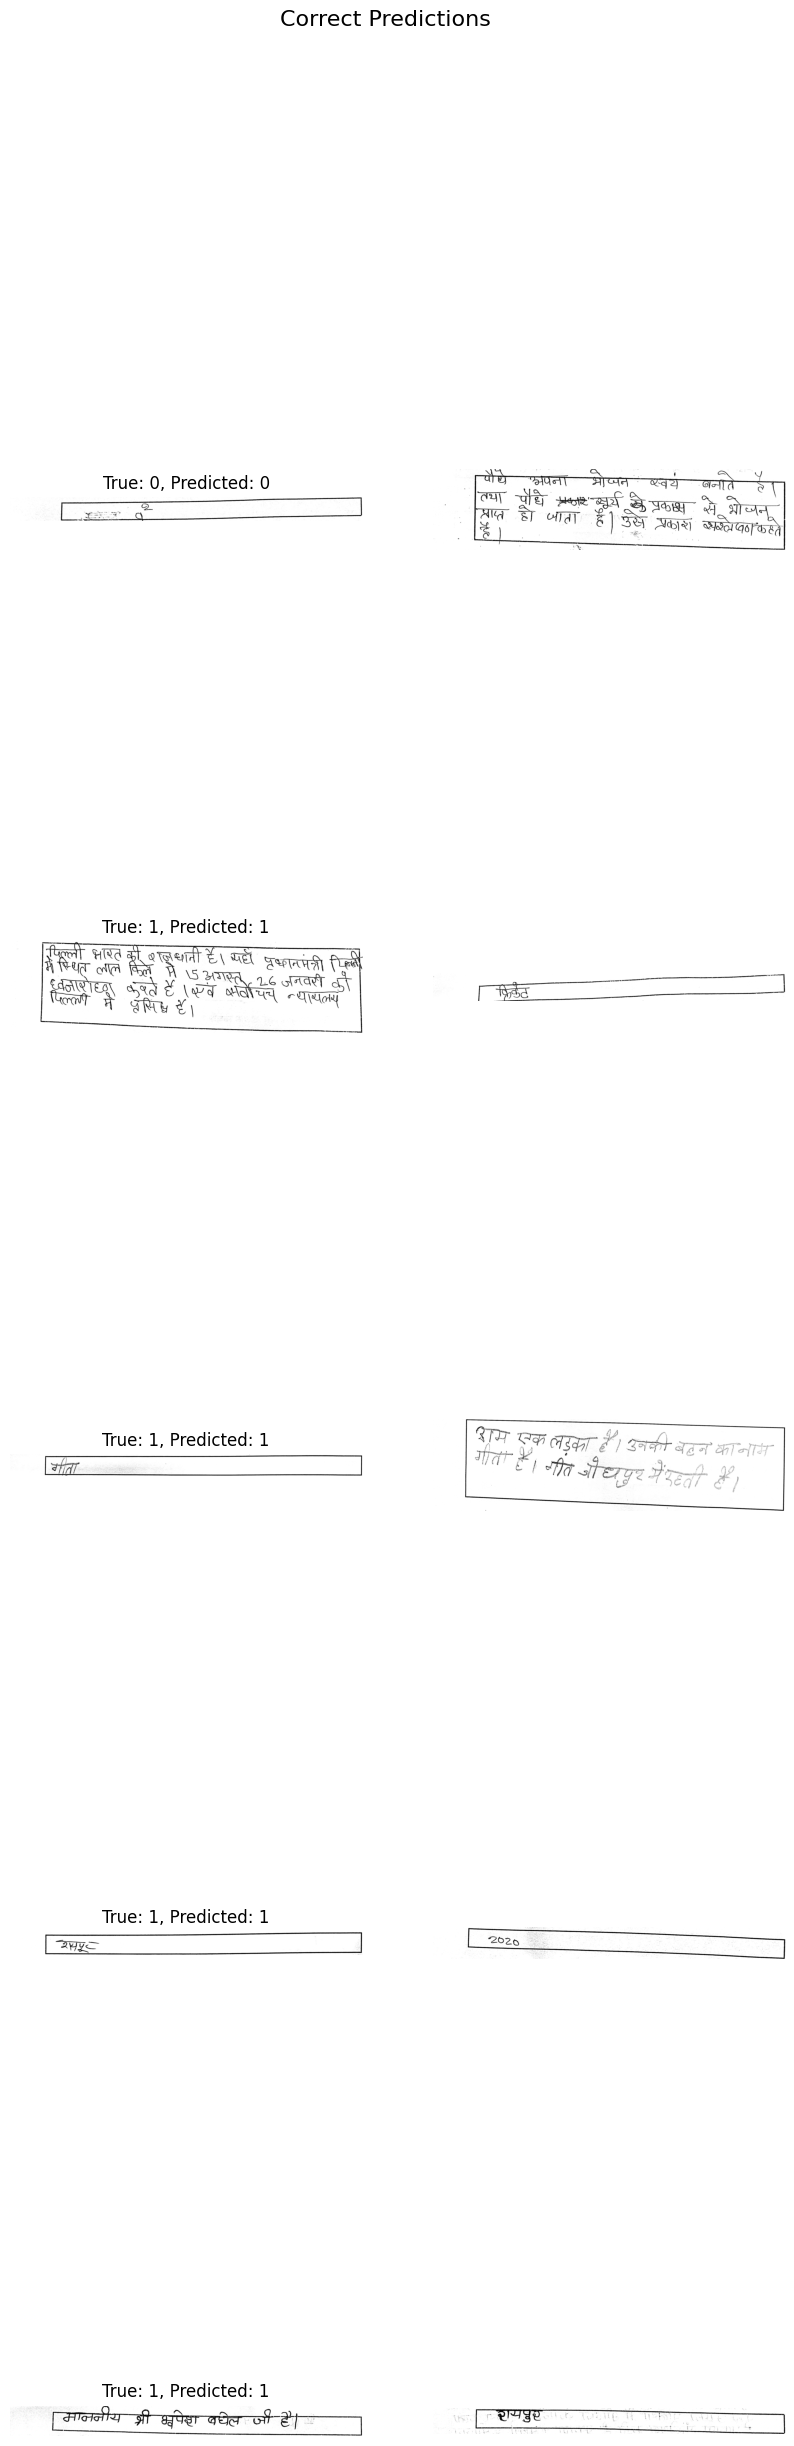

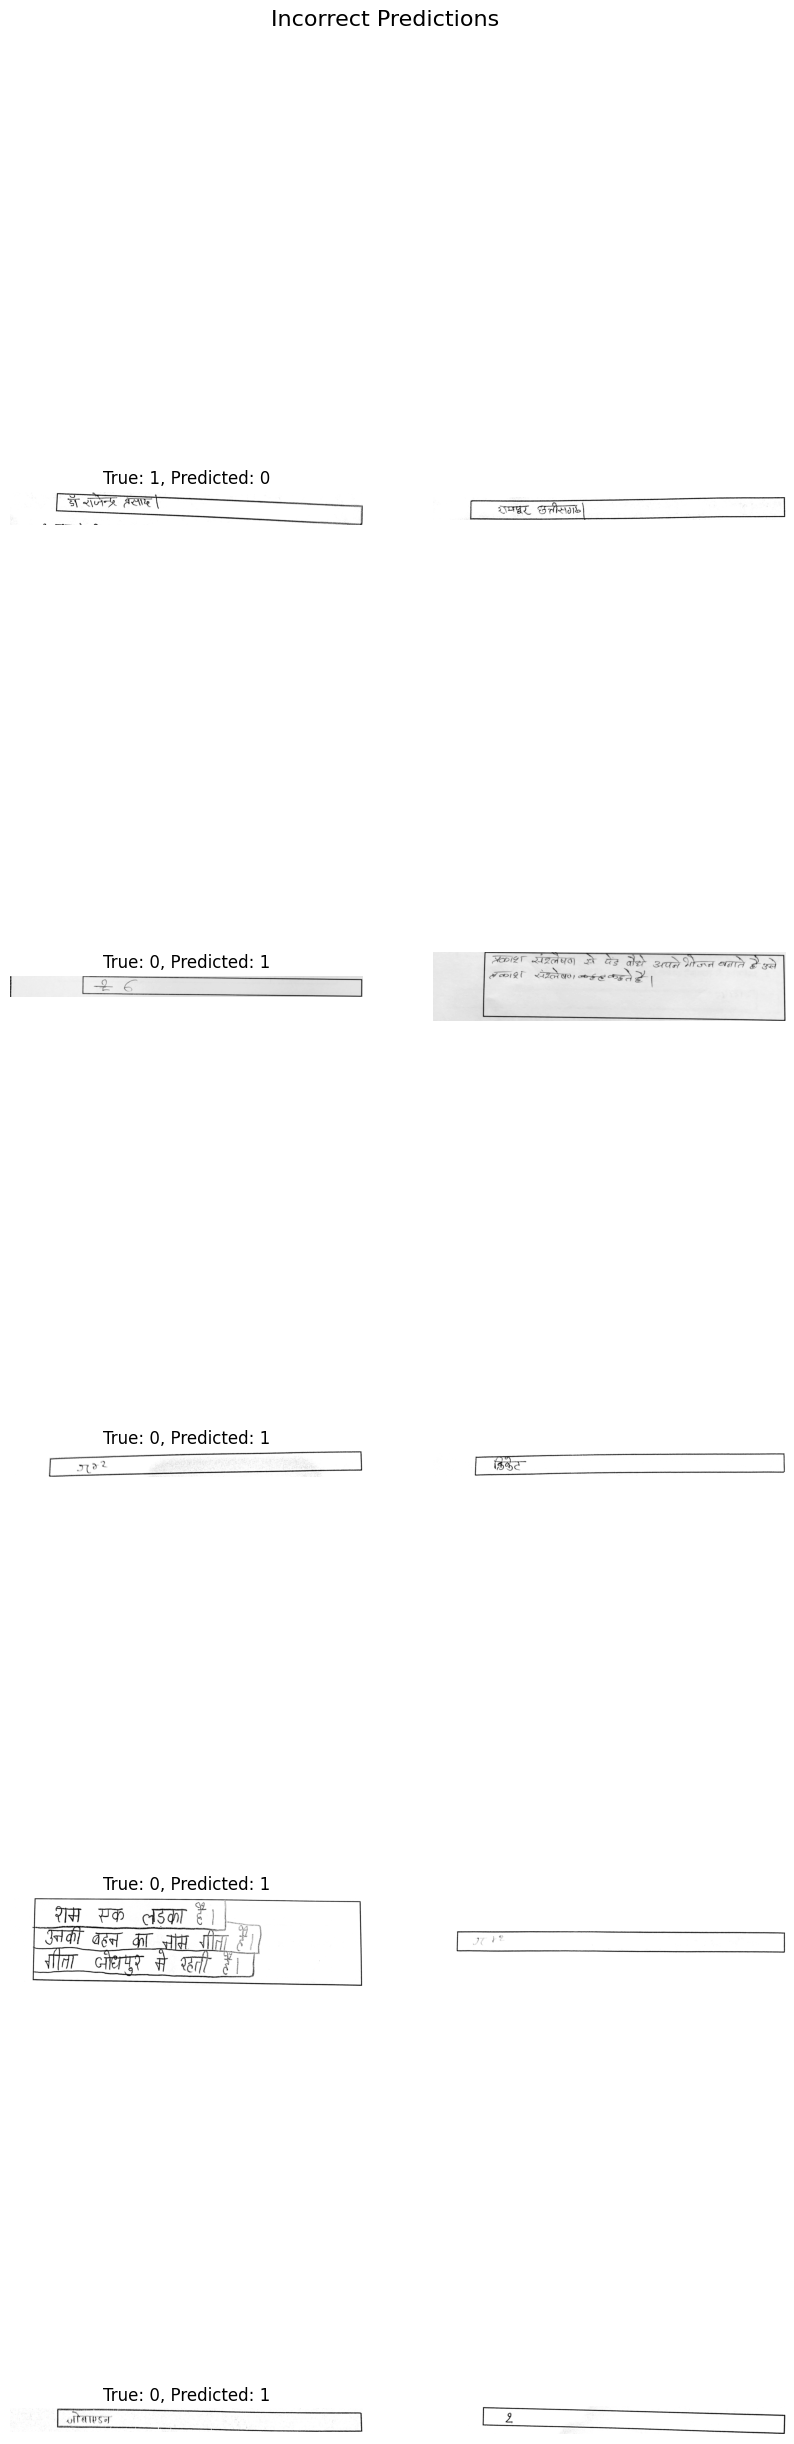

In [ ]:
correct_pred_indices = np.where(train_labels == predicted_labels)[0]
incorrect_pred_indices = np.where(train_labels != predicted_labels)[0]

import matplotlib.pyplot as plt
from PIL import Image

# Visualize 5 correct predictions
plt.figure(figsize=(10, 30))
for i, idx in enumerate(correct_pred_indices[:5]):
    plt.subplot(5, 2, 2*i+1)
    img_location1 = training_data.iloc[idx][0]
    img1 = Image.open(img_location1)
    plt.imshow(np.array(img1), cmap='gray')
    plt.title(f'True: {train_labels[idx]}, Predicted: {predicted_labels[idx]}')
    plt.axis('off')

    plt.subplot(5, 2, 2*i+2)
    img_location2 = training_data.iloc[idx][1]
    img2 = Image.open(img_location2)
    plt.imshow(np.array(img2), cmap='gray')
    plt.axis('off')

plt.suptitle('Correct Predictions', fontsize=16)
plt.show()

# Visualize 5 incorrect predictions
plt.figure(figsize=(10, 30))
for i, idx in enumerate(incorrect_pred_indices[:5]):
    plt.subplot(5, 2, 2*i+1)
    img_location1 = training_data.iloc[idx][0]
    img1 = Image.open(img_location1)
    plt.imshow(np.array(img1), cmap='gray')
    plt.title(f'True: {train_labels[idx]}, Predicted: {predicted_labels[idx]}')
    plt.axis('off')

    plt.subplot(5, 2, 2*i+2)
    img_location2 = training_data.iloc[idx][1]
    img2 = Image.open(img_location2)
    plt.imshow(np.array(img2), cmap='gray')
    plt.axis('off')

plt.suptitle('Incorrect Predictions', fontsize=16)
plt.show()


Upon Validation set

In [ ]:
with open('/content/drive/MyDrive/dataset/SaraSwati_Writes_Final_Model.pkl', 'rb') as f:
    siamese_model = pickle.load(f)
knn = joblib.load('/content/drive/MyDrive/dataset/knn_model.pkl')

val_data=pd.read_csv("/content/drive/MyDrive/dataset/val.csv")
val_data_copy = val_data.copy()
string_to_concat = "/content/drive/MyDrive/dataset/val/"
val_data_copy.iloc[:, 0:2] = string_to_concat + val_data_copy.iloc[:, 0:2].astype(str)
val_features = extract_features(net,val_data_copy.iloc[:100,0:2])
val_features=np.array(val_features)
val_features_reshaped = np.squeeze(val_features)
val_features_reshaped = np.reshape(val_features_reshaped, val_features.shape)
val_features_flattened = np.reshape(val_features_reshaped, (val_features.shape[0], -1))
val_features_flattened.shape

validation_data=val_data_copy.iloc[:100,0:2]
val_labels = np.asarray(val_data['label'].iloc[:100])
predicted_labels, _ = knn_predict( np.array(val_features_flattened))


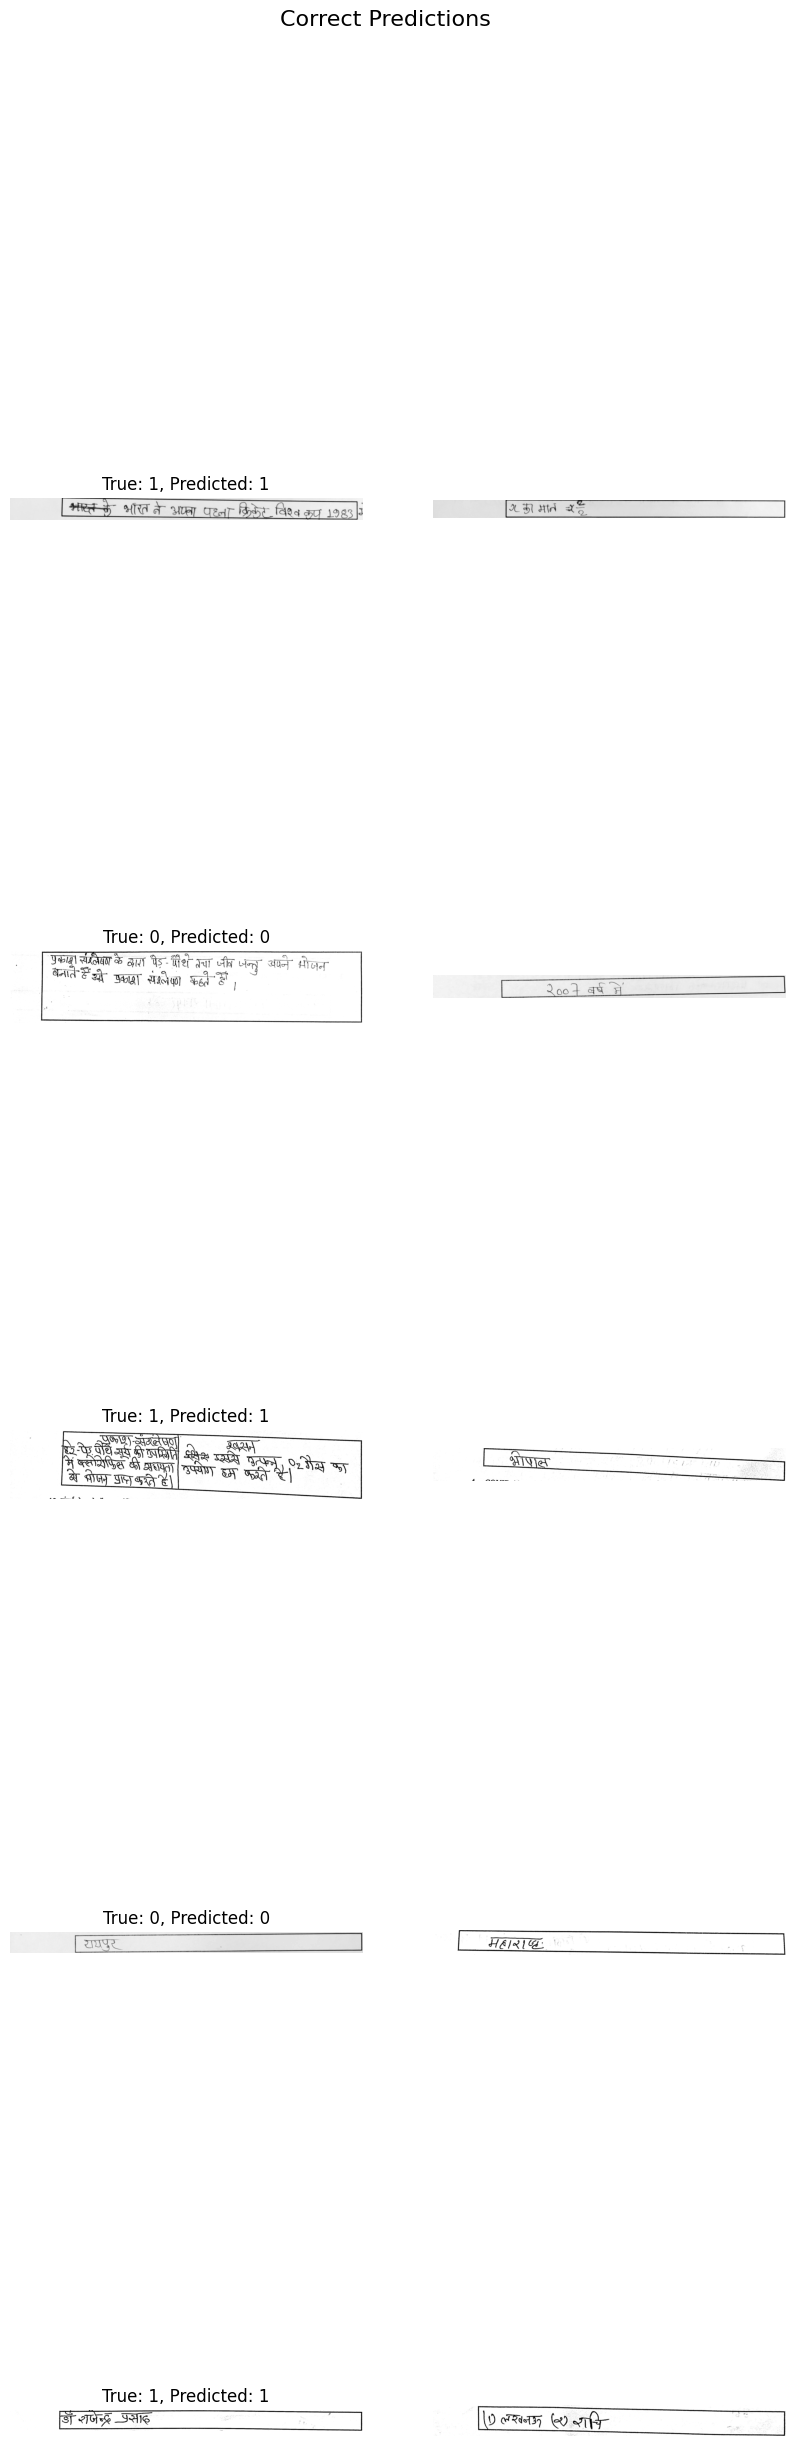

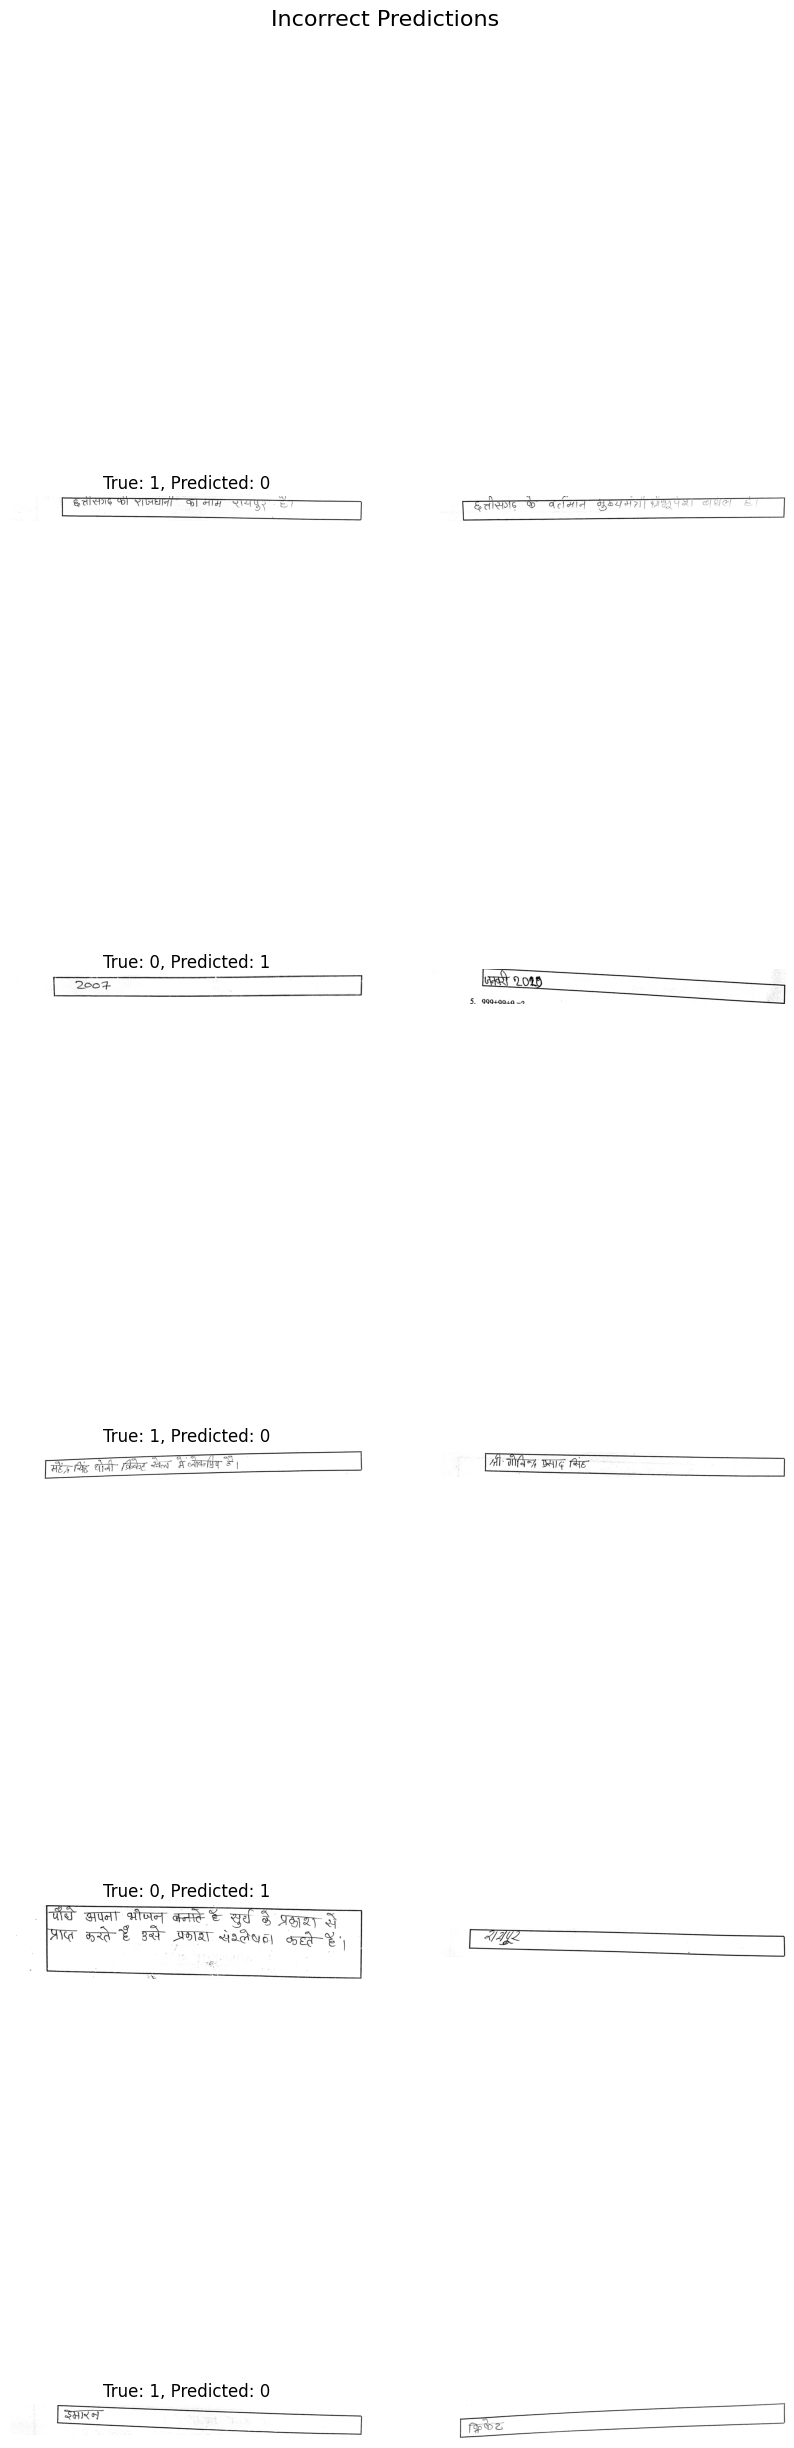

In [ ]:
correct_pred_indices = np.where(val_labels == predicted_labels)[0]
incorrect_pred_indices = np.where(val_labels != predicted_labels)[0]

import matplotlib.pyplot as plt
from PIL import Image

# Visualize 5 correct predictions
plt.figure(figsize=(10, 30))
for i, idx in enumerate(correct_pred_indices[:5]):
    plt.subplot(5, 2, 2*i+1)
    img_location1 = validation_data.iloc[idx][0]
    img1 = Image.open(img_location1)
    plt.imshow(np.array(img1), cmap='gray')
    plt.title(f'True: {val_labels[idx]}, Predicted: {predicted_labels[idx]}')
    plt.axis('off')

    plt.subplot(5, 2, 2*i+2)
    img_location2 = validation_data.iloc[idx][1]
    img2 = Image.open(img_location2)
    plt.imshow(np.array(img2), cmap='gray')
    plt.axis('off')

plt.suptitle('Correct Predictions', fontsize=16)
plt.show()

# Visualize 5 incorrect predictions
plt.figure(figsize=(10, 30))
for i, idx in enumerate(incorrect_pred_indices[:5]):
    plt.subplot(5, 2, 2*i+1)
    img_location1 = validation_data.iloc[idx][0]
    img1 = Image.open(img_location1)
    plt.imshow(np.array(img1), cmap='gray')
    plt.title(f'True: {val_labels[idx]}, Predicted: {predicted_labels[idx]}')
    plt.axis('off')

    plt.subplot(5, 2, 2*i+2)
    img_location2 = validation_data.iloc[idx][1]
    img2 = Image.open(img_location2)
    plt.imshow(np.array(img2), cmap='gray')
    plt.axis('off')

plt.suptitle('Incorrect Predictions', fontsize=16)
plt.show()


# Testing

In [ ]:
test_data=pd.read_csv("/content/drive/MyDrive/dataset/test.csv")
test_data_copy = test_data.copy()

string_to_concat = "/content/drive/MyDrive/dataset/semi_test/"

test_data_copy.iloc[:, 0:2] = string_to_concat + test_data_copy.iloc[:, 0:2].astype(str)

test_features = extract_features(net,test_data_copy)


In [ ]:
test_features=np.array(test_features)

In [ ]:
test_features_reshaped = np.squeeze(test_features)
print(test_features_reshaped.shape)

test_features_reshaped = np.reshape(test_features_reshaped, test_features.shape)

test_features_flattened = np.reshape(test_features_reshaped, (test_features.shape[0], -1))
test_features_flattened.shape

(10586, 2, 128)


(10586, 256)

In [ ]:
predicted_test_labels, test_probabilities = knn_predict(np.array(test_features_flattened))

In [ ]:
test_probabilities

array([0.9 , 0.98, 0.84, ..., 0.22, 0.94, 0.  ])

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_data['img1_name']+'_'+test_data['img2_name']
submission['proba'] = test_probabilities
submission.to_csv('/content/drive/MyDrive/dataset/SSWrites_Semi_final_Submission.csv', index=False)

In [ ]:
submission.shape

(10586, 2)